# Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains

Tinkering around with a fun paper. Set myself a time-limit of 2 hours until final push; this notebook is kind of messy..

Source:
https://arxiv.org/pdf/2006.10739.pdf

In [30]:
import matplotlib.pyplot as plt
import os, imageio
from jax import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

rand_key = random.PRNGKey(0)

[344, 512]


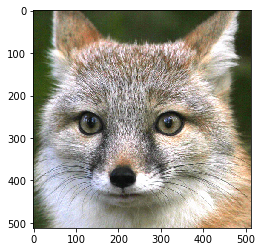

In [26]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
print(c)
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)

x_test = np.stack(np.meshgrid(coords, coords), -1)

test_data = [x_test, img]
train_data = [x_test[::2,::2], img[::2,::2]]



In [81]:
# Create Model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(3, activation='sigmoid'))


In [44]:
import datetime
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_data[0], train_data[1], epochs=1000, 
                    validation_data=(test_data[0], test_data[1]), callbacks=[tensorboard_callback])

Epoch 1/1000
8/8 [==============================] - 0s 47ms/step - loss: 0.0482 - accuracy: 0.6623 - val_loss: 0.0473 - val_accuracy: 0.6722
Epoch 2/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0470 - accuracy: 0.6833 - val_loss: 0.0466 - val_accuracy: 0.6828
Epoch 3/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0462 - accuracy: 0.6831 - val_loss: 0.0459 - val_accuracy: 0.6904
Epoch 4/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0453 - accuracy: 0.6919 - val_loss: 0.0449 - val_accuracy: 0.6888
Epoch 5/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0445 - accuracy: 0.6909 - val_loss: 0.0443 - val_accuracy: 0.6941
Epoch 6/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0437 - accuracy: 0.6879 - val_loss: 0.0434 - val_accuracy: 0.6922
Epoch 7/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0429 - accuracy: 0.6967 - val_loss: 0.0423 - val_accuracy: 0.6965
Epoch 8/1000


Epoch 59/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0258 - accuracy: 0.7320 - val_loss: 0.0257 - val_accuracy: 0.7390
Epoch 60/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0252 - accuracy: 0.7349 - val_loss: 0.0251 - val_accuracy: 0.7327
Epoch 61/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0251 - accuracy: 0.7271 - val_loss: 0.0247 - val_accuracy: 0.7348
Epoch 62/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0248 - accuracy: 0.7352 - val_loss: 0.0246 - val_accuracy: 0.7343
Epoch 63/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0250 - accuracy: 0.7289 - val_loss: 0.0259 - val_accuracy: 0.7268
Epoch 64/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0255 - accuracy: 0.7330 - val_loss: 0.0245 - val_accuracy: 0.7391
Epoch 65/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0250 - accuracy: 0.7352 - val_loss: 0.0260 - val_accuracy: 0.7298
Epoch 

8/8 [==============================] - 0s 39ms/step - loss: 0.0217 - accuracy: 0.7585 - val_loss: 0.0210 - val_accuracy: 0.7579
Epoch 117/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0211 - accuracy: 0.7555 - val_loss: 0.0207 - val_accuracy: 0.7610
Epoch 118/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0210 - accuracy: 0.7573 - val_loss: 0.0206 - val_accuracy: 0.7630
Epoch 119/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0209 - accuracy: 0.7590 - val_loss: 0.0209 - val_accuracy: 0.7571
Epoch 120/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0209 - accuracy: 0.7590 - val_loss: 0.0214 - val_accuracy: 0.7541
Epoch 121/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0210 - accuracy: 0.7589 - val_loss: 0.0220 - val_accuracy: 0.7534
Epoch 122/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0212 - accuracy: 0.7572 - val_loss: 0.0203 - val_accuracy: 0.7581
Epoch 123/1000

8/8 [==============================] - 0s 42ms/step - loss: 0.0187 - accuracy: 0.7701 - val_loss: 0.0189 - val_accuracy: 0.7698
Epoch 174/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0195 - accuracy: 0.7669 - val_loss: 0.0190 - val_accuracy: 0.7660
Epoch 175/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0195 - accuracy: 0.7681 - val_loss: 0.0189 - val_accuracy: 0.7730
Epoch 176/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0188 - accuracy: 0.7698 - val_loss: 0.0193 - val_accuracy: 0.7747
Epoch 177/1000
8/8 [==============================] - 0s 43ms/step - loss: 0.0189 - accuracy: 0.7701 - val_loss: 0.0187 - val_accuracy: 0.7696
Epoch 178/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0189 - accuracy: 0.7693 - val_loss: 0.0219 - val_accuracy: 0.7668
Epoch 179/1000
8/8 [==============================] - 0s 43ms/step - loss: 0.0198 - accuracy: 0.7700 - val_loss: 0.0198 - val_accuracy: 0.7713
Epoch 180/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0170 - accuracy: 0.7745 - val_loss: 0.0171 - val_accuracy: 0.7743
Epoch 231/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0169 - accuracy: 0.7741 - val_loss: 0.0168 - val_accuracy: 0.7756
Epoch 232/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0169 - accuracy: 0.7744 - val_loss: 0.0167 - val_accuracy: 0.7733
Epoch 233/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0167 - accuracy: 0.7755 - val_loss: 0.0165 - val_accuracy: 0.7755
Epoch 234/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0164 - accuracy: 0.7745 - val_loss: 0.0164 - val_accuracy: 0.7759
Epoch 235/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0168 - accuracy: 0.7749 - val_loss: 0.0171 - val_accuracy: 0.7769
Epoch 236/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0174 - accuracy: 0.7735 - val_loss: 0.0181 - val_accuracy: 0.7752
Epoch 237/1000

8/8 [==============================] - 0s 40ms/step - loss: 0.0157 - accuracy: 0.7758 - val_loss: 0.0162 - val_accuracy: 0.7708
Epoch 288/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0159 - accuracy: 0.7741 - val_loss: 0.0158 - val_accuracy: 0.7777
Epoch 289/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0157 - accuracy: 0.7758 - val_loss: 0.0155 - val_accuracy: 0.7744
Epoch 290/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0157 - accuracy: 0.7737 - val_loss: 0.0166 - val_accuracy: 0.7737
Epoch 291/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0161 - accuracy: 0.7736 - val_loss: 0.0165 - val_accuracy: 0.7767
Epoch 292/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0162 - accuracy: 0.7757 - val_loss: 0.0158 - val_accuracy: 0.7763
Epoch 293/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0157 - accuracy: 0.7751 - val_loss: 0.0155 - val_accuracy: 0.7701
Epoch 294/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0152 - accuracy: 0.7707 - val_loss: 0.0153 - val_accuracy: 0.7728
Epoch 345/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0152 - accuracy: 0.7730 - val_loss: 0.0152 - val_accuracy: 0.7761
Epoch 346/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0152 - accuracy: 0.7751 - val_loss: 0.0155 - val_accuracy: 0.7678
Epoch 347/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0153 - accuracy: 0.7691 - val_loss: 0.0153 - val_accuracy: 0.7725
Epoch 348/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0154 - accuracy: 0.7719 - val_loss: 0.0152 - val_accuracy: 0.7751
Epoch 349/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0153 - accuracy: 0.7736 - val_loss: 0.0156 - val_accuracy: 0.7711
Epoch 350/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0155 - accuracy: 0.7721 - val_loss: 0.0154 - val_accuracy: 0.7681
Epoch 351/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0151 - accuracy: 0.7733 - val_loss: 0.0153 - val_accuracy: 0.7737
Epoch 402/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0151 - accuracy: 0.7715 - val_loss: 0.0144 - val_accuracy: 0.7740
Epoch 403/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0145 - accuracy: 0.7731 - val_loss: 0.0155 - val_accuracy: 0.7736
Epoch 404/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0148 - accuracy: 0.7724 - val_loss: 0.0150 - val_accuracy: 0.7760
Epoch 405/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0146 - accuracy: 0.7727 - val_loss: 0.0143 - val_accuracy: 0.7701
Epoch 406/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0144 - accuracy: 0.7719 - val_loss: 0.0145 - val_accuracy: 0.7742
Epoch 407/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0146 - accuracy: 0.7729 - val_loss: 0.0144 - val_accuracy: 0.7703
Epoch 408/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0140 - accuracy: 0.7694 - val_loss: 0.0153 - val_accuracy: 0.7735
Epoch 459/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0145 - accuracy: 0.7722 - val_loss: 0.0143 - val_accuracy: 0.7725
Epoch 460/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0151 - accuracy: 0.7712 - val_loss: 0.0141 - val_accuracy: 0.7715
Epoch 461/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0154 - accuracy: 0.7686 - val_loss: 0.0164 - val_accuracy: 0.7644
Epoch 462/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0165 - accuracy: 0.7701 - val_loss: 0.0149 - val_accuracy: 0.7767
Epoch 463/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0162 - accuracy: 0.7701 - val_loss: 0.0172 - val_accuracy: 0.7660
Epoch 464/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0165 - accuracy: 0.7697 - val_loss: 0.0147 - val_accuracy: 0.7740
Epoch 465/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0135 - accuracy: 0.7698 - val_loss: 0.0140 - val_accuracy: 0.7718
Epoch 516/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0139 - accuracy: 0.7679 - val_loss: 0.0135 - val_accuracy: 0.7705
Epoch 517/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0138 - accuracy: 0.7697 - val_loss: 0.0142 - val_accuracy: 0.7675
Epoch 518/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0137 - accuracy: 0.7672 - val_loss: 0.0136 - val_accuracy: 0.7709
Epoch 519/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0133 - accuracy: 0.7724 - val_loss: 0.0133 - val_accuracy: 0.7739
Epoch 520/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0132 - accuracy: 0.7700 - val_loss: 0.0131 - val_accuracy: 0.7711
Epoch 521/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0132 - accuracy: 0.7697 - val_loss: 0.0134 - val_accuracy: 0.7714
Epoch 522/1000

8/8 [==============================] - 0s 40ms/step - loss: 0.0141 - accuracy: 0.7677 - val_loss: 0.0150 - val_accuracy: 0.7641
Epoch 573/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0141 - accuracy: 0.7681 - val_loss: 0.0134 - val_accuracy: 0.7758
Epoch 574/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0131 - accuracy: 0.7710 - val_loss: 0.0127 - val_accuracy: 0.7680
Epoch 575/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0132 - accuracy: 0.7672 - val_loss: 0.0131 - val_accuracy: 0.7676
Epoch 576/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0132 - accuracy: 0.7673 - val_loss: 0.0135 - val_accuracy: 0.7698
Epoch 577/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0134 - accuracy: 0.7690 - val_loss: 0.0133 - val_accuracy: 0.7724
Epoch 578/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0135 - accuracy: 0.7694 - val_loss: 0.0136 - val_accuracy: 0.7714
Epoch 579/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0124 - accuracy: 0.7664 - val_loss: 0.0124 - val_accuracy: 0.7705
Epoch 630/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0130 - accuracy: 0.7684 - val_loss: 0.0125 - val_accuracy: 0.7702
Epoch 631/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0127 - accuracy: 0.7693 - val_loss: 0.0124 - val_accuracy: 0.7696
Epoch 632/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0125 - accuracy: 0.7667 - val_loss: 0.0128 - val_accuracy: 0.7672
Epoch 633/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0126 - accuracy: 0.7657 - val_loss: 0.0128 - val_accuracy: 0.7700
Epoch 634/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0127 - accuracy: 0.7682 - val_loss: 0.0124 - val_accuracy: 0.7677
Epoch 635/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0124 - accuracy: 0.7682 - val_loss: 0.0125 - val_accuracy: 0.7656
Epoch 636/1000

8/8 [==============================] - 0s 40ms/step - loss: 0.0124 - accuracy: 0.7682 - val_loss: 0.0124 - val_accuracy: 0.7659
Epoch 687/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0125 - accuracy: 0.7680 - val_loss: 0.0132 - val_accuracy: 0.7656
Epoch 688/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0132 - accuracy: 0.7703 - val_loss: 0.0131 - val_accuracy: 0.7653
Epoch 689/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0130 - accuracy: 0.7669 - val_loss: 0.0121 - val_accuracy: 0.7669
Epoch 690/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0123 - accuracy: 0.7671 - val_loss: 0.0123 - val_accuracy: 0.7677
Epoch 691/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0121 - accuracy: 0.7666 - val_loss: 0.0123 - val_accuracy: 0.7706
Epoch 692/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0121 - accuracy: 0.7674 - val_loss: 0.0120 - val_accuracy: 0.7673
Epoch 693/1000

8/8 [==============================] - 0s 40ms/step - loss: 0.0120 - accuracy: 0.7678 - val_loss: 0.0119 - val_accuracy: 0.7685
Epoch 744/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0120 - accuracy: 0.7671 - val_loss: 0.0117 - val_accuracy: 0.7704
Epoch 745/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0119 - accuracy: 0.7667 - val_loss: 0.0121 - val_accuracy: 0.7693
Epoch 746/1000
8/8 [==============================] - 0s 43ms/step - loss: 0.0119 - accuracy: 0.7701 - val_loss: 0.0117 - val_accuracy: 0.7713
Epoch 747/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0118 - accuracy: 0.7679 - val_loss: 0.0117 - val_accuracy: 0.7659
Epoch 748/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0117 - accuracy: 0.7666 - val_loss: 0.0116 - val_accuracy: 0.7684
Epoch 749/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0117 - accuracy: 0.7682 - val_loss: 0.0120 - val_accuracy: 0.7707
Epoch 750/1000

8/8 [==============================] - 0s 41ms/step - loss: 0.0121 - accuracy: 0.7688 - val_loss: 0.0121 - val_accuracy: 0.7683
Epoch 801/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0118 - accuracy: 0.7693 - val_loss: 0.0118 - val_accuracy: 0.7709
Epoch 802/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0121 - accuracy: 0.7673 - val_loss: 0.0121 - val_accuracy: 0.7677
Epoch 803/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0118 - accuracy: 0.7667 - val_loss: 0.0124 - val_accuracy: 0.7699
Epoch 804/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0121 - accuracy: 0.7706 - val_loss: 0.0126 - val_accuracy: 0.7725
Epoch 805/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0122 - accuracy: 0.7688 - val_loss: 0.0115 - val_accuracy: 0.7676
Epoch 806/1000
8/8 [==============================] - 0s 42ms/step - loss: 0.0117 - accuracy: 0.7660 - val_loss: 0.0119 - val_accuracy: 0.7680
Epoch 807/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0118 - accuracy: 0.7692 - val_loss: 0.0115 - val_accuracy: 0.7688
Epoch 858/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0117 - accuracy: 0.7676 - val_loss: 0.0115 - val_accuracy: 0.7667
Epoch 859/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0114 - accuracy: 0.7681 - val_loss: 0.0120 - val_accuracy: 0.7675
Epoch 860/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0115 - accuracy: 0.7700 - val_loss: 0.0117 - val_accuracy: 0.7708
Epoch 861/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0116 - accuracy: 0.7674 - val_loss: 0.0118 - val_accuracy: 0.7592
Epoch 862/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0115 - accuracy: 0.7661 - val_loss: 0.0113 - val_accuracy: 0.7687
Epoch 863/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0114 - accuracy: 0.7696 - val_loss: 0.0114 - val_accuracy: 0.7685
Epoch 864/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0113 - accuracy: 0.7690 - val_loss: 0.0116 - val_accuracy: 0.7683
Epoch 915/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0111 - accuracy: 0.7690 - val_loss: 0.0110 - val_accuracy: 0.7694
Epoch 916/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0110 - accuracy: 0.7691 - val_loss: 0.0112 - val_accuracy: 0.7684
Epoch 917/1000
8/8 [==============================] - 0s 38ms/step - loss: 0.0112 - accuracy: 0.7706 - val_loss: 0.0128 - val_accuracy: 0.7650
Epoch 918/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0119 - accuracy: 0.7679 - val_loss: 0.0123 - val_accuracy: 0.7672
Epoch 919/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0119 - accuracy: 0.7693 - val_loss: 0.0136 - val_accuracy: 0.7659
Epoch 920/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0126 - accuracy: 0.7685 - val_loss: 0.0139 - val_accuracy: 0.7625
Epoch 921/1000

8/8 [==============================] - 0s 39ms/step - loss: 0.0109 - accuracy: 0.7700 - val_loss: 0.0110 - val_accuracy: 0.7699
Epoch 972/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0108 - accuracy: 0.7685 - val_loss: 0.0109 - val_accuracy: 0.7683
Epoch 973/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.0109 - accuracy: 0.7681 - val_loss: 0.0113 - val_accuracy: 0.7715
Epoch 974/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0115 - accuracy: 0.7700 - val_loss: 0.0155 - val_accuracy: 0.7720
Epoch 975/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.0137 - accuracy: 0.7688 - val_loss: 0.0139 - val_accuracy: 0.7734
Epoch 976/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0123 - accuracy: 0.7697 - val_loss: 0.0118 - val_accuracy: 0.7675
Epoch 977/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.0114 - accuracy: 0.7670 - val_loss: 0.0115 - val_accuracy: 0.7708
Epoch 978/1000

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (32, None, 256)           768       
_________________________________________________________________
dense_12 (Dense)             (32, None, 256)           65792     
_________________________________________________________________
dense_13 (Dense)             (32, None, 256)           65792     
_________________________________________________________________
dense_14 (Dense)             (32, None, 3)             771       
Total params: 133,123
Trainable params: 133,123
Non-trainable params: 0
_________________________________________________________________


Unfortunately, a MLP with 133,123 params is not able to memorize an image with size of 256x256. It can not handle the required bandwith to represent such an image with the low-dimensional input of out xy-coordinate. The image appears blurred.

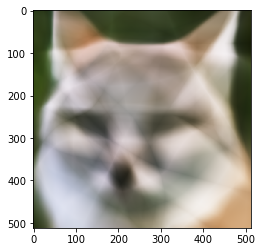

In [45]:
predictions = model.predict(test_data[0])
plt.imshow(predictions)

In [54]:
# Fourier feature mapping
def input_mapping(x, B): 
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

On why we choose the factor 10 for the Gaussian scale:

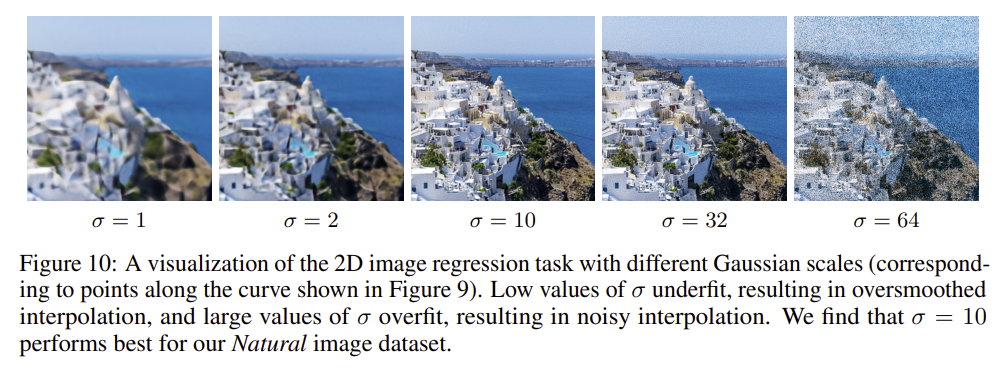
Source: https://arxiv.org/pdf/2006.10739.pdf

In [65]:
input_size = 256
scale = 10
B = random.normal(rand_key, shape =(input_size, 2))*scale

In [87]:
import datetime
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(input_mapping(train_data[0], B), train_data[1], epochs=1000, 
                    validation_data=(input_mapping(test_data[0], B), test_data[1]), callbacks=[tensorboard_callback])

Epoch 1/1000
8/8 [==============================] - 1s 86ms/step - loss: 0.0629 - accuracy: 0.4470 - val_loss: 0.0500 - val_accuracy: 0.4897
Epoch 2/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0420 - accuracy: 0.5109 - val_loss: 0.0304 - val_accuracy: 0.5698
Epoch 3/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0241 - accuracy: 0.5923 - val_loss: 0.0179 - val_accuracy: 0.5977
Epoch 4/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0150 - accuracy: 0.6192 - val_loss: 0.0113 - val_accuracy: 0.6448
Epoch 5/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0103 - accuracy: 0.6386 - val_loss: 0.0091 - val_accuracy: 0.6405
Epoch 6/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0086 - accuracy: 0.6626 - val_loss: 0.0079 - val_accuracy: 0.6806
Epoch 7/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0076 - accuracy: 0.6818 - val_loss: 0.0074 - val_accuracy: 0.6970
Epoch 8/1000


Epoch 59/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0036 - accuracy: 0.7846 - val_loss: 0.0044 - val_accuracy: 0.7843
Epoch 60/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0037 - accuracy: 0.7858 - val_loss: 0.0047 - val_accuracy: 0.7825
Epoch 61/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0037 - accuracy: 0.7852 - val_loss: 0.0045 - val_accuracy: 0.7753
Epoch 62/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0036 - accuracy: 0.7831 - val_loss: 0.0045 - val_accuracy: 0.7833
Epoch 63/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0038 - accuracy: 0.7852 - val_loss: 0.0047 - val_accuracy: 0.7881
Epoch 64/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0037 - accuracy: 0.7859 - val_loss: 0.0046 - val_accuracy: 0.7867
Epoch 65/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0037 - accuracy: 0.7853 - val_loss: 0.0047 - val_accuracy: 0.7865
Epoch 

8/8 [==============================] - 1s 65ms/step - loss: 0.0025 - accuracy: 0.7931 - val_loss: 0.0037 - val_accuracy: 0.7922
Epoch 117/1000
8/8 [==============================] - 1s 64ms/step - loss: 0.0025 - accuracy: 0.7937 - val_loss: 0.0037 - val_accuracy: 0.7911
Epoch 118/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0026 - accuracy: 0.7926 - val_loss: 0.0045 - val_accuracy: 0.7925
Epoch 119/1000
8/8 [==============================] - 1s 64ms/step - loss: 0.0030 - accuracy: 0.7927 - val_loss: 0.0039 - val_accuracy: 0.7948
Epoch 120/1000
8/8 [==============================] - 1s 64ms/step - loss: 0.0030 - accuracy: 0.7933 - val_loss: 0.0038 - val_accuracy: 0.7913
Epoch 121/1000
8/8 [==============================] - 1s 64ms/step - loss: 0.0031 - accuracy: 0.7909 - val_loss: 0.0040 - val_accuracy: 0.7909
Epoch 122/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0030 - accuracy: 0.7926 - val_loss: 0.0040 - val_accuracy: 0.7944
Epoch 123/1000

8/8 [==============================] - 0s 62ms/step - loss: 0.0018 - accuracy: 0.7977 - val_loss: 0.0034 - val_accuracy: 0.7944
Epoch 174/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0018 - accuracy: 0.7988 - val_loss: 0.0033 - val_accuracy: 0.7969
Epoch 175/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0017 - accuracy: 0.7986 - val_loss: 0.0035 - val_accuracy: 0.7923
Epoch 176/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0019 - accuracy: 0.7981 - val_loss: 0.0040 - val_accuracy: 0.7949
Epoch 177/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0025 - accuracy: 0.7977 - val_loss: 0.0047 - val_accuracy: 0.7959
Epoch 178/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0022 - accuracy: 0.7987 - val_loss: 0.0037 - val_accuracy: 0.7938
Epoch 179/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0021 - accuracy: 0.7974 - val_loss: 0.0041 - val_accuracy: 0.7892
Epoch 180/1000

8/8 [==============================] - 0s 62ms/step - loss: 0.0015 - accuracy: 0.8019 - val_loss: 0.0032 - val_accuracy: 0.7983
Epoch 231/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 0.8018 - val_loss: 0.0032 - val_accuracy: 0.8007
Epoch 232/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0016 - accuracy: 0.8029 - val_loss: 0.0033 - val_accuracy: 0.8002
Epoch 233/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 0.8011 - val_loss: 0.0032 - val_accuracy: 0.7972
Epoch 234/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0016 - accuracy: 0.8020 - val_loss: 0.0032 - val_accuracy: 0.8000
Epoch 235/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0016 - accuracy: 0.8022 - val_loss: 0.0035 - val_accuracy: 0.7991
Epoch 236/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0018 - accuracy: 0.8034 - val_loss: 0.0042 - val_accuracy: 0.7995
Epoch 237/1000

8/8 [==============================] - 0s 62ms/step - loss: 0.0018 - accuracy: 0.8038 - val_loss: 0.0035 - val_accuracy: 0.7979
Epoch 288/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0017 - accuracy: 0.8028 - val_loss: 0.0034 - val_accuracy: 0.8031
Epoch 289/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 0.8040 - val_loss: 0.0035 - val_accuracy: 0.7993
Epoch 290/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0015 - accuracy: 0.8046 - val_loss: 0.0033 - val_accuracy: 0.8004
Epoch 291/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0014 - accuracy: 0.8045 - val_loss: 0.0033 - val_accuracy: 0.8005
Epoch 292/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0014 - accuracy: 0.8038 - val_loss: 0.0034 - val_accuracy: 0.8024
Epoch 293/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0015 - accuracy: 0.8039 - val_loss: 0.0033 - val_accuracy: 0.8000
Epoch 294/1000

8/8 [==============================] - 0s 61ms/step - loss: 9.9570e-04 - accuracy: 0.8087 - val_loss: 0.0030 - val_accuracy: 0.8047
Epoch 345/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.5935e-04 - accuracy: 0.8089 - val_loss: 0.0030 - val_accuracy: 0.8024
Epoch 346/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.3890e-04 - accuracy: 0.8101 - val_loss: 0.0030 - val_accuracy: 0.8045
Epoch 347/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.1837e-04 - accuracy: 0.8094 - val_loss: 0.0030 - val_accuracy: 0.8041
Epoch 348/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.0394e-04 - accuracy: 0.8100 - val_loss: 0.0030 - val_accuracy: 0.8041
Epoch 349/1000
8/8 [==============================] - 1s 64ms/step - loss: 8.8680e-04 - accuracy: 0.8106 - val_loss: 0.0030 - val_accuracy: 0.8041
Epoch 350/1000
8/8 [==============================] - 0s 62ms/step - loss: 8.6398e-04 - accuracy: 0.8106 - val_loss: 0.0030 - val_acc

Epoch 401/1000
8/8 [==============================] - 1s 66ms/step - loss: 8.3192e-04 - accuracy: 0.8129 - val_loss: 0.0030 - val_accuracy: 0.8062
Epoch 402/1000
8/8 [==============================] - 1s 68ms/step - loss: 8.2025e-04 - accuracy: 0.8125 - val_loss: 0.0030 - val_accuracy: 0.8058
Epoch 403/1000
8/8 [==============================] - 1s 66ms/step - loss: 7.9911e-04 - accuracy: 0.8134 - val_loss: 0.0030 - val_accuracy: 0.8071
Epoch 404/1000
8/8 [==============================] - 1s 63ms/step - loss: 8.0112e-04 - accuracy: 0.8138 - val_loss: 0.0031 - val_accuracy: 0.8069
Epoch 405/1000
8/8 [==============================] - 0s 62ms/step - loss: 8.4027e-04 - accuracy: 0.8120 - val_loss: 0.0030 - val_accuracy: 0.8051
Epoch 406/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.8399e-04 - accuracy: 0.8118 - val_loss: 0.0033 - val_accuracy: 0.8046
Epoch 407/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0010 - accuracy: 0.8126 - val_loss: 0.003

8/8 [==============================] - 0s 62ms/step - loss: 0.0013 - accuracy: 0.8128 - val_loss: 0.0037 - val_accuracy: 0.8062
Epoch 458/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 0.8109 - val_loss: 0.0034 - val_accuracy: 0.8050
Epoch 459/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0019 - accuracy: 0.8091 - val_loss: 0.0034 - val_accuracy: 0.8035
Epoch 460/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0018 - accuracy: 0.8090 - val_loss: 0.0042 - val_accuracy: 0.8039
Epoch 461/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0025 - accuracy: 0.8072 - val_loss: 0.0062 - val_accuracy: 0.7905
Epoch 462/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0034 - accuracy: 0.8031 - val_loss: 0.0074 - val_accuracy: 0.7847
Epoch 463/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0034 - accuracy: 0.7994 - val_loss: 0.0042 - val_accuracy: 0.7992
Epoch 464/1000

8/8 [==============================] - 1s 64ms/step - loss: 9.8516e-04 - accuracy: 0.8154 - val_loss: 0.0033 - val_accuracy: 0.8051
Epoch 514/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0011 - accuracy: 0.8149 - val_loss: 0.0033 - val_accuracy: 0.8057
Epoch 515/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0012 - accuracy: 0.8137 - val_loss: 0.0032 - val_accuracy: 0.8067
Epoch 516/1000
8/8 [==============================] - 0s 61ms/step - loss: 0.0012 - accuracy: 0.8136 - val_loss: 0.0035 - val_accuracy: 0.8060
Epoch 517/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0013 - accuracy: 0.8112 - val_loss: 0.0032 - val_accuracy: 0.8089
Epoch 518/1000
8/8 [==============================] - 1s 64ms/step - loss: 0.0012 - accuracy: 0.8120 - val_loss: 0.0035 - val_accuracy: 0.8059
Epoch 519/1000
8/8 [==============================] - 1s 63ms/step - loss: 0.0012 - accuracy: 0.8122 - val_loss: 0.0032 - val_accuracy: 0.8042
Epoch 520/

Epoch 570/1000
8/8 [==============================] - 0s 62ms/step - loss: 6.5632e-04 - accuracy: 0.8175 - val_loss: 0.0029 - val_accuracy: 0.8121
Epoch 571/1000
8/8 [==============================] - 0s 61ms/step - loss: 6.3042e-04 - accuracy: 0.8176 - val_loss: 0.0029 - val_accuracy: 0.8128
Epoch 572/1000
8/8 [==============================] - 0s 62ms/step - loss: 6.3427e-04 - accuracy: 0.8186 - val_loss: 0.0030 - val_accuracy: 0.8084
Epoch 573/1000
8/8 [==============================] - 0s 62ms/step - loss: 6.2462e-04 - accuracy: 0.8180 - val_loss: 0.0029 - val_accuracy: 0.8087
Epoch 574/1000
8/8 [==============================] - 0s 62ms/step - loss: 6.2575e-04 - accuracy: 0.8190 - val_loss: 0.0029 - val_accuracy: 0.8113
Epoch 575/1000
8/8 [==============================] - 1s 63ms/step - loss: 6.1105e-04 - accuracy: 0.8189 - val_loss: 0.0030 - val_accuracy: 0.8099
Epoch 576/1000
8/8 [==============================] - 1s 64ms/step - loss: 6.4664e-04 - accuracy: 0.8176 - val_loss: 0

8/8 [==============================] - 1s 67ms/step - loss: 5.1404e-04 - accuracy: 0.8202 - val_loss: 0.0029 - val_accuracy: 0.8128
Epoch 627/1000
8/8 [==============================] - 1s 67ms/step - loss: 5.1608e-04 - accuracy: 0.8202 - val_loss: 0.0029 - val_accuracy: 0.8126
Epoch 628/1000
8/8 [==============================] - 1s 65ms/step - loss: 5.1729e-04 - accuracy: 0.8210 - val_loss: 0.0029 - val_accuracy: 0.8086
Epoch 629/1000
8/8 [==============================] - 1s 66ms/step - loss: 5.2054e-04 - accuracy: 0.8212 - val_loss: 0.0029 - val_accuracy: 0.8120
Epoch 630/1000
8/8 [==============================] - 1s 65ms/step - loss: 5.3911e-04 - accuracy: 0.8195 - val_loss: 0.0029 - val_accuracy: 0.8125
Epoch 631/1000
8/8 [==============================] - 1s 68ms/step - loss: 5.6789e-04 - accuracy: 0.8211 - val_loss: 0.0029 - val_accuracy: 0.8117
Epoch 632/1000
8/8 [==============================] - 1s 67ms/step - loss: 5.9855e-04 - accuracy: 0.8203 - val_loss: 0.0030 - val_acc

8/8 [==============================] - 1s 65ms/step - loss: 5.1755e-04 - accuracy: 0.8226 - val_loss: 0.0029 - val_accuracy: 0.8128
Epoch 683/1000
8/8 [==============================] - 1s 67ms/step - loss: 6.1155e-04 - accuracy: 0.8217 - val_loss: 0.0030 - val_accuracy: 0.8128
Epoch 684/1000
8/8 [==============================] - 1s 65ms/step - loss: 5.6445e-04 - accuracy: 0.8222 - val_loss: 0.0029 - val_accuracy: 0.8072
Epoch 685/1000
8/8 [==============================] - 1s 65ms/step - loss: 5.5768e-04 - accuracy: 0.8206 - val_loss: 0.0029 - val_accuracy: 0.8076
Epoch 686/1000
8/8 [==============================] - 1s 64ms/step - loss: 5.7648e-04 - accuracy: 0.8215 - val_loss: 0.0031 - val_accuracy: 0.8110
Epoch 687/1000
8/8 [==============================] - 1s 66ms/step - loss: 8.2004e-04 - accuracy: 0.8202 - val_loss: 0.0036 - val_accuracy: 0.8134
Epoch 688/1000
8/8 [==============================] - 1s 66ms/step - loss: 0.0012 - accuracy: 0.8180 - val_loss: 0.0041 - val_accurac

8/8 [==============================] - 1s 63ms/step - loss: 6.0637e-04 - accuracy: 0.8215 - val_loss: 0.0030 - val_accuracy: 0.8091
Epoch 739/1000
8/8 [==============================] - 0s 62ms/step - loss: 5.5920e-04 - accuracy: 0.8217 - val_loss: 0.0029 - val_accuracy: 0.8106
Epoch 740/1000
8/8 [==============================] - 0s 62ms/step - loss: 5.4969e-04 - accuracy: 0.8208 - val_loss: 0.0030 - val_accuracy: 0.8111
Epoch 741/1000
8/8 [==============================] - 0s 62ms/step - loss: 5.5936e-04 - accuracy: 0.8234 - val_loss: 0.0029 - val_accuracy: 0.8117
Epoch 742/1000
8/8 [==============================] - 0s 62ms/step - loss: 5.4231e-04 - accuracy: 0.8222 - val_loss: 0.0029 - val_accuracy: 0.8155
Epoch 743/1000
8/8 [==============================] - 1s 63ms/step - loss: 5.5616e-04 - accuracy: 0.8229 - val_loss: 0.0029 - val_accuracy: 0.8168
Epoch 744/1000
8/8 [==============================] - 1s 64ms/step - loss: 5.3632e-04 - accuracy: 0.8234 - val_loss: 0.0029 - val_acc

8/8 [==============================] - 1s 66ms/step - loss: 8.9952e-04 - accuracy: 0.8158 - val_loss: 0.0032 - val_accuracy: 0.8083
Epoch 795/1000
8/8 [==============================] - 1s 69ms/step - loss: 8.9075e-04 - accuracy: 0.8168 - val_loss: 0.0031 - val_accuracy: 0.8090
Epoch 796/1000
8/8 [==============================] - 1s 67ms/step - loss: 8.6903e-04 - accuracy: 0.8185 - val_loss: 0.0031 - val_accuracy: 0.8108
Epoch 797/1000
8/8 [==============================] - 1s 65ms/step - loss: 8.0997e-04 - accuracy: 0.8184 - val_loss: 0.0030 - val_accuracy: 0.8160
Epoch 798/1000
8/8 [==============================] - 1s 64ms/step - loss: 7.2494e-04 - accuracy: 0.8199 - val_loss: 0.0031 - val_accuracy: 0.8113
Epoch 799/1000
8/8 [==============================] - 0s 62ms/step - loss: 7.8200e-04 - accuracy: 0.8211 - val_loss: 0.0031 - val_accuracy: 0.8086
Epoch 800/1000
8/8 [==============================] - 1s 64ms/step - loss: 8.0661e-04 - accuracy: 0.8212 - val_loss: 0.0031 - val_acc

8/8 [==============================] - 1s 63ms/step - loss: 8.4502e-04 - accuracy: 0.8187 - val_loss: 0.0032 - val_accuracy: 0.8091
Epoch 851/1000
8/8 [==============================] - 0s 62ms/step - loss: 8.4599e-04 - accuracy: 0.8214 - val_loss: 0.0030 - val_accuracy: 0.8138
Epoch 852/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0011 - accuracy: 0.8223 - val_loss: 0.0039 - val_accuracy: 0.8105
Epoch 853/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 0.8207 - val_loss: 0.0036 - val_accuracy: 0.8081
Epoch 854/1000
8/8 [==============================] - 0s 62ms/step - loss: 0.0012 - accuracy: 0.8172 - val_loss: 0.0032 - val_accuracy: 0.8054
Epoch 855/1000
8/8 [==============================] - 0s 62ms/step - loss: 9.9014e-04 - accuracy: 0.8170 - val_loss: 0.0031 - val_accuracy: 0.8100
Epoch 856/1000
8/8 [==============================] - 0s 62ms/step - loss: 8.2510e-04 - accuracy: 0.8187 - val_loss: 0.0030 - val_accuracy: 0.812

8/8 [==============================] - 0s 62ms/step - loss: 9.2101e-04 - accuracy: 0.8134 - val_loss: 0.0030 - val_accuracy: 0.8021
Epoch 907/1000
8/8 [==============================] - 0s 62ms/step - loss: 7.7803e-04 - accuracy: 0.8170 - val_loss: 0.0030 - val_accuracy: 0.8057
Epoch 908/1000
8/8 [==============================] - 0s 62ms/step - loss: 6.6635e-04 - accuracy: 0.8201 - val_loss: 0.0029 - val_accuracy: 0.8094
Epoch 909/1000
8/8 [==============================] - 0s 62ms/step - loss: 5.7556e-04 - accuracy: 0.8218 - val_loss: 0.0029 - val_accuracy: 0.8136
Epoch 910/1000
8/8 [==============================] - 1s 63ms/step - loss: 5.2407e-04 - accuracy: 0.8236 - val_loss: 0.0029 - val_accuracy: 0.8127
Epoch 911/1000
8/8 [==============================] - 1s 63ms/step - loss: 4.9355e-04 - accuracy: 0.8247 - val_loss: 0.0029 - val_accuracy: 0.8142
Epoch 912/1000
8/8 [==============================] - 1s 66ms/step - loss: 4.7725e-04 - accuracy: 0.8255 - val_loss: 0.0029 - val_acc

8/8 [==============================] - 1s 63ms/step - loss: 3.6331e-04 - accuracy: 0.8306 - val_loss: 0.0028 - val_accuracy: 0.8169
Epoch 963/1000
8/8 [==============================] - 0s 62ms/step - loss: 3.4546e-04 - accuracy: 0.8311 - val_loss: 0.0028 - val_accuracy: 0.8193
Epoch 964/1000
8/8 [==============================] - 0s 62ms/step - loss: 3.3115e-04 - accuracy: 0.8310 - val_loss: 0.0028 - val_accuracy: 0.8166
Epoch 965/1000
8/8 [==============================] - 1s 63ms/step - loss: 3.2110e-04 - accuracy: 0.8310 - val_loss: 0.0028 - val_accuracy: 0.8185
Epoch 966/1000
8/8 [==============================] - 1s 63ms/step - loss: 3.2569e-04 - accuracy: 0.8322 - val_loss: 0.0028 - val_accuracy: 0.8180
Epoch 967/1000
8/8 [==============================] - 0s 62ms/step - loss: 3.3893e-04 - accuracy: 0.8321 - val_loss: 0.0028 - val_accuracy: 0.8155
Epoch 968/1000
8/8 [==============================] - 1s 65ms/step - loss: 3.6772e-04 - accuracy: 0.8324 - val_loss: 0.0028 - val_acc

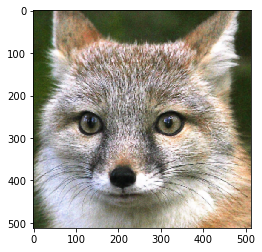

In [89]:
predictions = model.predict(input_mapping(test_data[0], B))
plt.imshow(predictions)